# Training Restricted Boltzmann Machines

This is an implementation of [Training restricted Boltzmann Machines: An introduction](https://www.sciencedirect.com/science/article/pii/S0031320313002495).
Restricted Boltzmann Machines (RBMs) are probabilistic graphical models, interpreted as stochastic neural networks, utilised primarily in Deep Belief nets.

An RBM can be thought of as a Markov Random Field associated with a bipartite undirected graph, consisting of m visible units (V), and n hidden units (H) to capture dependencies between the observed variables.

The graph of an RBM has connetions only between the layer of hidden and the layer of visible variables, but not between any two variables of the same layer, as shown below

![img](./imm/rbm_fig.png)

## Learning procedures implemented

Learning RBMs means learning (important aspects of) an unknown distribution based on sample data. This includes finding new representations of the data that foster learning, generalisation, and communication. A standard way of estimating their parameters is through maximum-likelihood estimation, which corresponds to minimising the distance between an unknown distribution undelying the data and the distribution of the RBM in terms of Kullback-Leibler divergence (KL divergence). Unfortunately, finding parameters by maximising the log-likelihood analytically is not possible as it requires computing the difference between two expectations:
* The expected values of the energy function under the model distribution, 
* and the expected values under the conditional distribution of the hidden variables given the training examples.
Directly computing these leads to a computational complexity which is in general exponential in the number of variables. To avoid this computational burden, the expectations can be approximated by samples drawn from the corresponding distribuions based on Markov Chain Monte Carlo (MCMC) technique (most commonly Gibbs sampling).
This means that the log-likelihood gradient given some data and perform gradient ascent on these approximations.

### Contrastive Divergence
The most common way of doing this is k-step Contrastive Divergence (CD) learning (usually k = 1 for most tasks), which involves running a Gibbs chain for just a few steps, which can be sufficient for estimating the gradient directions and therefore train an RBM.

The idea of k-step CD is quite simple: instead of approximating the computationally expensive term in the log-likelihood gradient by a sample from the RBM-distribution (which would require running a Markov chain until the stationary distribution is reached), a Gibbs chain is run.

### Parallel Tempering
Parallel tempering (PT) is one of the most promising sampling techniques used for RBM training. It introduces supplementary Gibbs chains that sample from more and more smoothed replicas of the original distribution.
This is performed by utilising an ordered set of temperatures for each of which a different Markov Chain with its stationary distribution is defined.

With increasing temperature the probabilty mass of the Gibbs distribution gets more and more equally distributed (or smoother), and thus the mixing of the corresponding Markov chain gets more and more facilitated. As the temperature reaches infinity the uniform distribution is reached, in which subsequent samples of the Gibbs chain are independent from each other, and thus the stationary distribution is reached after just one sampling step.

In each step of the algorithm (k) Gibbs sampling steps in each tempered Markov chain. Subsequently, two neighboring Gibbs chains (characterised by their frequenies) may exchange particles with an exchange probability based on the metropolis ratio.

After performing these swaps between the chains, which increase the mixing rate, the exchanged sample of the original chain is taken as a sample from the RBM distribution.
This procedure is repeated a number of times, yielding the samples used for the final approximation of the computationally expensive term.

Compared to CD, PT introduces computational overhead, but produces a more quickly mixing Markov chain, and thus a less biased gradient approximation, which can lead to better learning.

Useful guidelines for training RBMs are given by Hinton, in his [Practical Guide to Training Restricted Boltzmann Machines](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)

## Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from random import sample

import torch
from torch.utils.data import DataLoader

from RBM import RBM # RBM class
from helpers import StratifiedSampler, MnistDataset

## Training

In [164]:
B_train = 200 # batch size for train set
B_test  = 10 # Batch size for test set

train_set = MnistDataset(image_path = './data/train-images-idx3-ubyte.gz',
                         label_path = './data/train-labels-idx1-ubyte.gz')

test_set = MnistDataset(image_path = './data/t10k-images-idx3-ubyte.gz',
                        label_path = './data/t10k-labels-idx1-ubyte.gz')

train_loader = DataLoader(train_set,
                          batch_size = B_train,
                          shuffle    = False,
                          sampler    = StratifiedSampler(train_set.labels, batch_size = B_train),
                          drop_last  = True)

test_loader = DataLoader(test_set,
                         batch_size = B_test,
                         shuffle    = False,
                         sampler    = StratifiedSampler(test_set.labels, batch_size = B_test),
                         drop_last  = False)

### k-step Contrastive Divergence

Let's train with kCD for various k- values:

In [165]:
kappas = np.linspace(start = 1, stop = 10, num = 5, dtype = int)
epochs = 10

# List to hold average reconstruction error for all batches (MSE error over all pixels)
history = np.empty(shape = (len(train_loader) * epochs, kappas.shape[0]))

for jj in tqdm(range(kappas.shape[0])): # Kappa loop
    
    # Init. RBM
    rbm = RBM(hidden_units = 100, 
          visible_units    = 784, # Visible units = 28 x 28 -> img. height x img.width
          learning_rate    = 5e-3)
    
    ii = 0 # Iteration counter

    for _ in tqdm(range(epochs), leave = False): # Epoch loop

        for X, _ in train_loader: # Batch loop

            # Run k-step CD
            error = rbm.ContrastiveDivergence(v = X.view(B_train, -1), # v: vector [batch x visible units]
                                              k = kappas[jj]) 

            # log reconstruction error
            history[ii, jj] = error
            ii += 1

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Let's have a look at the reconstruction errors for each k:

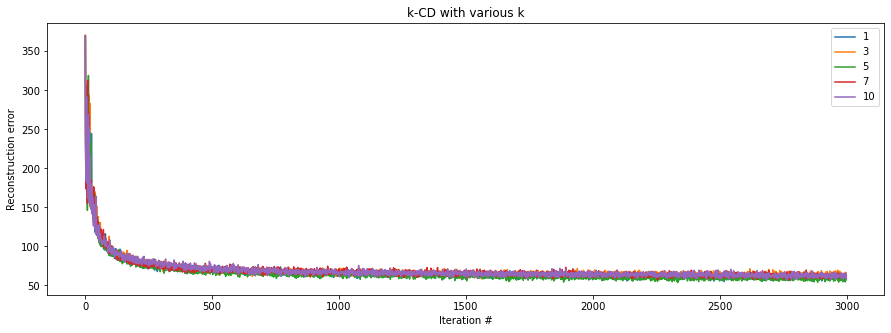

In [169]:
plt.figure(figsize = (15, 5))
for jj, k in enumerate(kappas):
    plt.plot(history[:, jj])
plt.legend(kappas)
plt.xlabel('Iteration #')
plt.ylabel('Reconstruction error')
plt.title('k-CD with various k')
plt.show();

### Parallel Tempering

Let's train with PT:

In [184]:
Nts    = np.array([4, 5, 10, 50], dtype = int) # No. Gibbs chains
epochs = 10

# List to hold average reconstruction error for all batches (MSE error over all pixels)
history = np.empty(shape = (len(train_loader) * epochs, Nts.shape[0]))

for jj in tqdm(range(Nts.shape[0])): # Kappa loop
    
    # Init. RBM
    rbm = RBM(hidden_units = 100, 
          visible_units    = 784,
          learning_rate    = 5e-3)
    
    ii = 0 # Iteration counter

    for _ in tqdm(range(epochs), leave = False): # Epoch loop

        for X, _ in train_loader: # Batch loop

            # Run k-step PT (k = 1)
            error = rbm.ParallelTempering(X  = X.view(B_train, -1),
                                          Nt = int(Nts[jj]),
                                          k  = 1)

            # log reconstruction error
            history[ii, jj] = error
            ii += 1

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Let's plot the reconstruction errors:

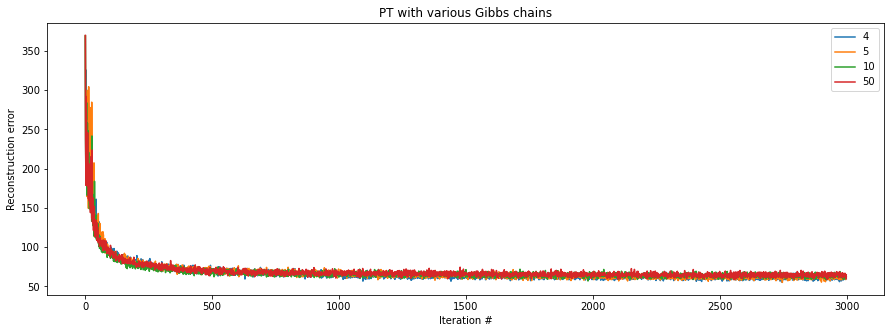

In [185]:
plt.figure(figsize = (15, 5))
for jj, _ in enumerate(Nts):
    plt.plot(history[:, jj])
plt.legend(Nts)
plt.xlabel('Iteration #')
plt.ylabel('Reconstruction error')
plt.title('PT with various Gibbs chains')
plt.show();

This seeems to be consistent. Let's train one RBM and see if it can fill in corrupted images:

In [259]:
# Init. RBM
rbm = RBM(hidden_units  = 100, 
          visible_units = 784, # Visible units = 28 x 28 -> img. height x img.width
          learning_rate = 5e-3
         )
    
history = []

for _ in tqdm(range(20)): # Epoch loop

    for X, _ in train_loader: # Batch loop

        # Run k-step CD
        error = rbm.ContrastiveDivergence(v = X.view(B_train, -1), # v: vector [batch x visible units]
                                          k = 1)

        history.append(error)

  0%|          | 0/20 [00:00<?, ?it/s]

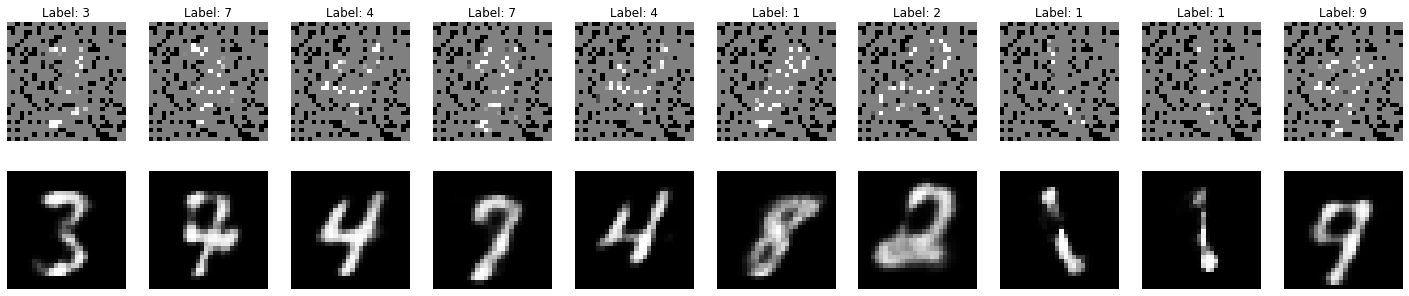

In [282]:
def plot_batch(batch_size, X, X_hat, labels):
    ''' Plots actual and predicted images for one batch'''
    
    fig, ax = plt.subplots(2, batch_size, figsize = (25, 5))

    for idx in range(batch_size):
        title = 'Label: ' + str(labels[idx])
        
        ax[0, idx].imshow(X[idx,:,:], 'gray')
        ax[0, idx].axis('off')
        ax[0, idx].set_title(title)
        
        ax[1, idx].imshow(X_hat[idx,:,:], 'gray')
        ax[1, idx].axis('off')
        
    return

for idx, (X, y) in enumerate(test_loader):

    # Make a copy of the batch
    v = torch.clone(X.view(B_test, -1))
    
    # Randomly hide pixels
    h_pix = sample(range(784), 600)
    v[:, h_pix] = 0
    
    # Sample with RBM
    _, _, vhat, _, _ = rbm.GibbsSampler(v, k = 1)
    
    # Plot results of the batch
    v[:, h_pix] = 0.5
    plot_batch(batch_size = B_test,
               X          = v.view(B_test, 28, -1).cpu().numpy(), 
               X_hat      = vhat.view(B_test, 28, -1).cpu().numpy(), 
               labels     = y.cpu().numpy())
    
    break

Not bad, not perfect. Nevetheless, the reconstructed images do match the labels.